In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#__author__ = 'Prakhar MISRA'
# Created 9/27/2017
#Last edit 9/27/2017

'''# Purpose: This code will read the MOD14 product to count the the pixels above certain FRP threshold to realte with agro fires '''

#Contents:
# 1. cosnider 10km, 20km, 30km radius neughborhood of the central pixel
# 2. count pixels greater than a threshold.
# 3. save this information at daily level and the annual level

# NOTE
# only plotfrp_annual, plotfrp_annual_bymonth works, linkis for aother functins are broken



import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import os.path
from glob import glob
from datetime import timedelta, date
from dateutil import rrule
from dateutil.relativedelta import relativedelta
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from itertools import product
# import os
# os.chdir('/home/prakhar/Research/AQM_research/Codes/')
import sys

sys.path.append('/home/prakhar/Research/AQM_research/Codes/')


# * * *  * * # * * * *  * *# # * * * *  * * # * * * *  * * # * * *#    Step0: Initialize     * * *  * * # * * * *  * *# # * * * *  * * # * * * *  * * # * * * *  * *#
#Input

#prefix
gb_path = r'/home/prakhar/Research/AQM_research//'    # global path tp be appended to each path from my folders
currdir = os.getcwd()


In [49]:
#mother godown
FRPpath = r'/home/wataru/research/MODIS/MOD14/forMIRAIKAN/'

# Output location
plt_save_path = gb_path + r'/Codes/PlotOut/AQFRP/'  # fig plot output path
csv_save_path = gb_path + r'Codes/CSVOut/AQFRP/'  # cas output path
exl_path = gb_path + r'/Docs prepared/Excel files//'  # excel saved files read path
img_save_path = gb_path + r'/Data\Data_process//'
csv_in_path = gb_path + '/Codes/CSVIn/'

# citylist : funxtion to generate distance image from city centre
citylist_path = os.path.join(currdir, "lib", "CityList_FRP.csv")

In [98]:



def get_val(dffrp, lat, lon, radius):
    # function to return the list of FRP of pixels surrounding the centre as frplist.
    # considers the datafrme of frp 'dffrp'
    # and lat and lon in degrees
    # and radius in kilometres
    #return a list frplist


    # 1 deg  = ~110km; 10km =~0.1deg; 1km = ~.01deg
    radiusdeg = radius*0.01

    #list of FRP of pixels surrounding the centre
    frplist = dffrp[(np.abs(dffrp.lat-lat)<=radiusdeg) & (np.abs(dffrp.lon-lon)<=radiusdeg)]['FRP'].tolist()

    return frplist
#function end

def summaryfrp(frplist, frpthreshold):
    # function to return the number of pixels above frp threshold and mean of those pixels
    # frplist  list of FRP of pixels surrounding the centre
    # frpthreshold threshold above frp is consiedered as fire

    abovefrp = [x  for x in frplist if x>= frpthreshold]

    return [np.size(abovefrp), np.nanmean(abovefrp)]
#function end

def getFRPinfo(frp_filepath,df_citylist, date, radius =500, frpthreshold = 10 ):
    #read the filepath and calls previous for the cities mentioned in citylistpath and returns a distilled frp list/df or whateva
    dffrp = pd.read_csv(frp_filepath)

    #assings name to columns becuase these are essentially column liess files
    dffrp.columns = ['lat', 'lon', 'FRP']

    #check for all cities
    lscount = []
    lsmean = []
    for index, cityrow in df_citylist.iterrows():
        #print cityrow['City']
        #get all qualifying frp vallues
        #provide the distane upto  whch fire must be counted
        frplist = get_val(dffrp, cityrow['Lat'], cityrow['Lon'], radius = radius)

        # get count above threshold and their mean
        #provide the threshold abov e which  to consider the FRP
        summary = summaryfrp(frplist, frpthreshold = frpthreshold)

        lscount.append(summary[0])
        lsmean.append(summary[1])
    lscount.append(date)
    lsmean.append(date)

    return (lscount,lsmean)
#function end


def getFRP(FRPpath,citylist_path ):


    #set radius and frpthreshold
    RADIUS = 200
    FRPTHRESHOLD = 30

    #function to produce df containing FRP mewtric of all cities
    lsfrpcount = []
    lsfrpmean = []

    df_citylist = pd.read_csv(citylist_path, header=0)

    for filepath in glob(os.path.join(FRPpath, '*'+'.csv')):

        #get date of the filepath
        date = filepath[-16:-8]
        print (date)

        try :
            (lscount, lsmean) = getFRPinfo(filepath,df_citylist, date, radius =RADIUS, frpthreshold = FRPTHRESHOLD)
            lsfrpcount.append(lscount)
            lsfrpmean.append(lsmean)
        except:
            continue

    #column names for df
    columns = df_citylist.Count.tolist()
    columns.append('date')
    df_count = pd.DataFrame(lsfrpcount, columns = columns )
    df_mean = pd.DataFrame(lsfrpmean, columns=columns)
    # save the df
    df_count.to_csv(csv_save_path+ 'df_20cityFRPcount_'+RADIUS+FRPTHRESHOLD+'.csv', header=True)
    df_mean.to_csv(csv_save_path + 'df_20cityFRPmean_'+RADIUS+FRPTHRESHOLD+'.csv', header=True)


def plotfrp_annual(df, Countid, cityname, labely, rolling = False):
    #function to plot the FRP trend for each city in the city

    #Countid = 'C02'
    #convert to datettime
    df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

    #getting the doy
    df['doy'] = df['date'].dt.dayofyear

    # new figure
    plt.figure()
    ax = plt.subplot(111)
    ax.set_color_cycle(sns.color_palette('coolwarm_r', 16))
    #plt.style.use('seaborn-dark-palette')
    #plotting for each year
    for yy in range(2001, 2017):

        #extract df for yy
        df_yy = df[df.date.dt.year==yy]

        #variables
        if rolling:
            x = pd.rolling_mean(df_yy.doy, 8)
            y = pd.rolling_mean(df_yy[Countid], 8)

        else:
             x = df_yy.doy
             y = df_yy[Countid]
        #y.fillna(0, inplace = True)

        #plot for this year
        ax.plot(x,y, label = np.str(yy))

    plt.legend()
    plt.xlabel('DOY')
    plt.ylabel(labely)
    plt.title(cityname)
    plt.savefig(os.path.join( currdir, "plots", "FRP", 'AnnualFRP'+labely+Countid +'.png'))
    plt.show()
#functio ned

def get_resmapled_df(df):
    
    #convert to datettime
    df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

    #getting the doy
    df['doy'] = df['date'].dt.dayofyear

    # first set the datetime index
    df = df.set_index("date")

    # get the FRP monthly sum of FRP
    resamplesumM = df.resample('M').apply('mean')

    # getting its month form the index
    resamplesumM["month"] = resamplesumM.index.month
    
    return resamplesumM

def plotfrp_annual_bymonth(df, Countid, cityname, labely, rolling = False):

    #function to plot the FRP trend for each city in the city    
    
    sns.set(font_scale=2)
    fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')


    ax = plt.subplot(111)
    ax.set_prop_cycle('color', sns.color_palette('coolwarm_r', 16))
    #plt.style.use('seaborn-dark-palette')
    #plotting for each years
    for yy in range(2001, 2017):

        #extract df for yy
        df_yy = df[df.index.year==yy]

        x = df_yy.month
        y = df_yy[Countid]
        #y.fillna(0, inplace = True)

        #plot for this year
        ax.plot(x,y, label = np.str(yy), linestyle='-', marker='+', alpha = 1)
        

    plt.legend()
    plt.xlabel('month')
    plt.ylabel('monthly mean fire count')
    plt.xlim([0,12])
    plt.ylim([0,200])
    plt.title(cityname)
    plt.legend(ncol = 2)
    plt.savefig(os.path.join( currdir, "plots", "FRP", 'AnnualFRP'+labely+Countid +'.png'))
    plt.tight_layout()
    plt.show()
    
    
#functio ned

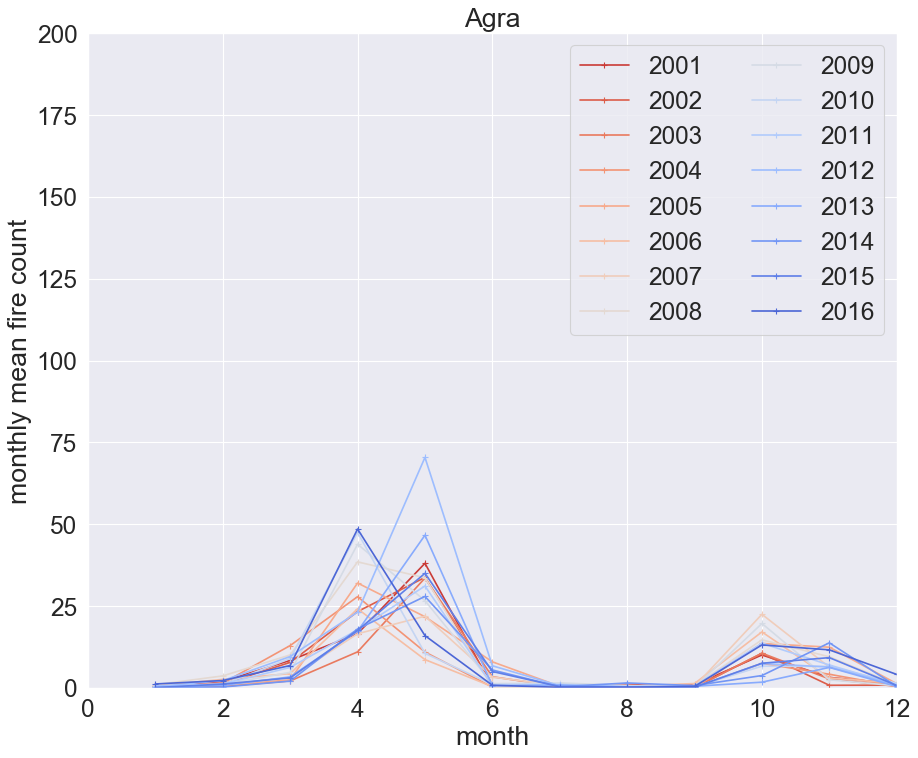

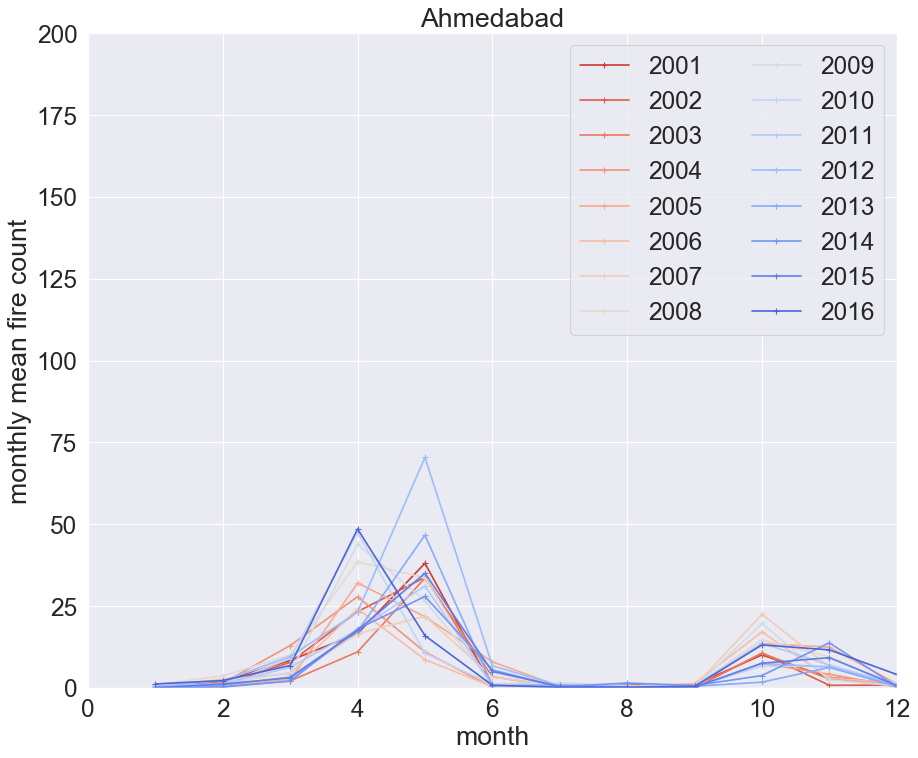

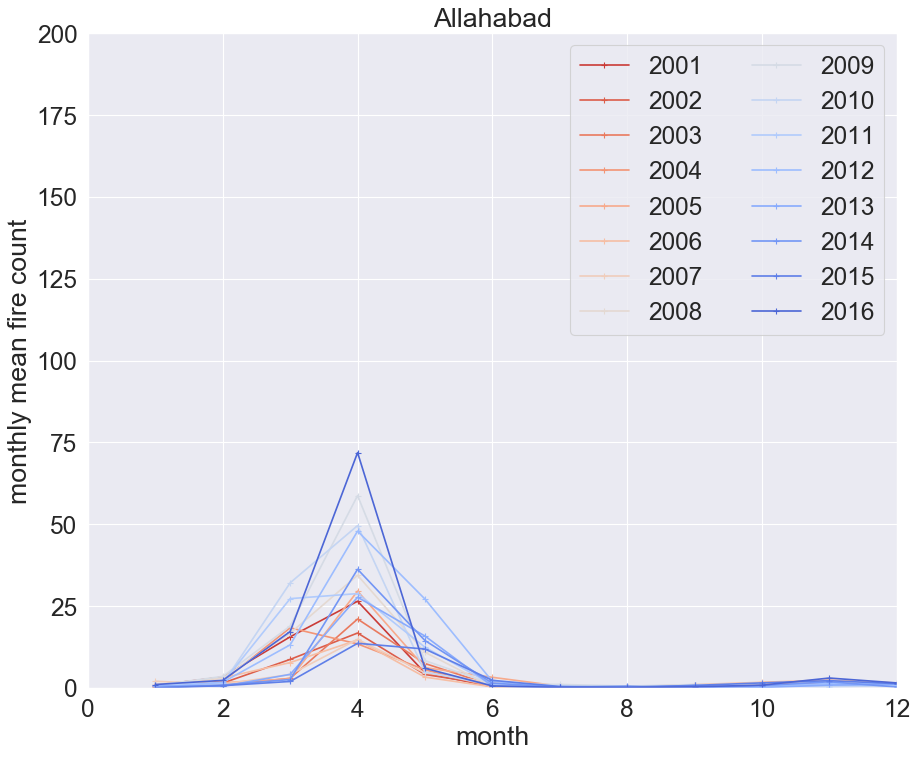

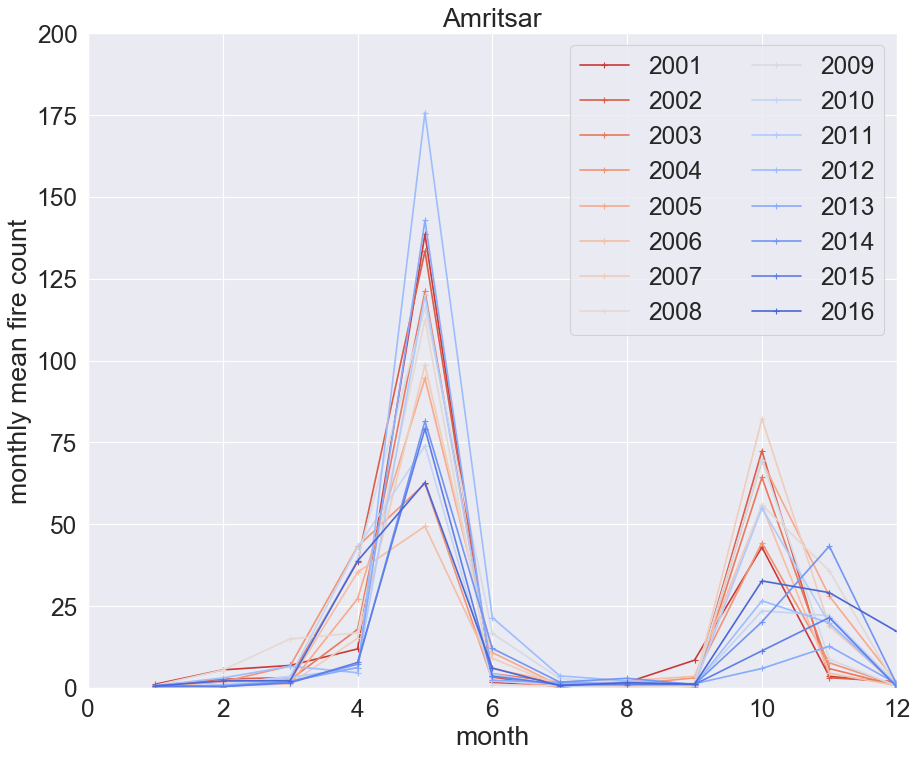

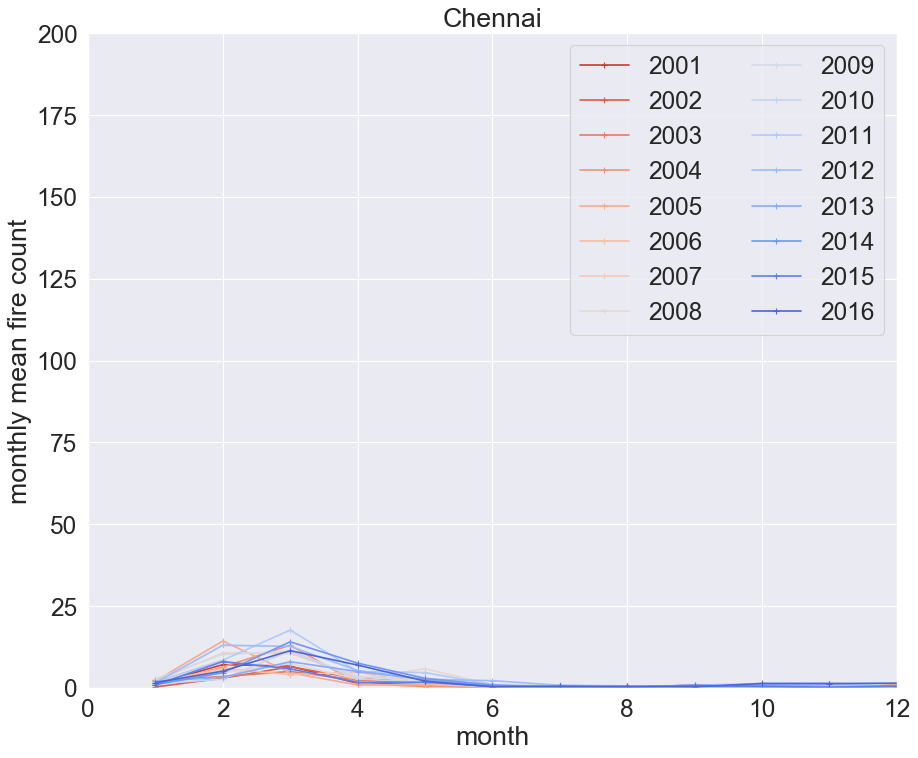

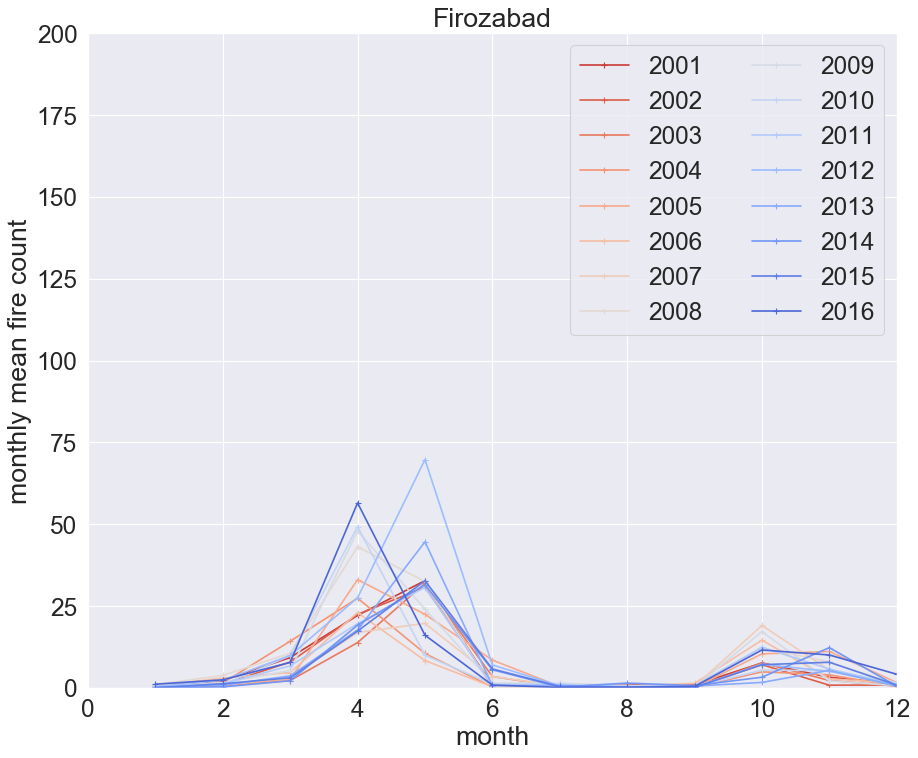

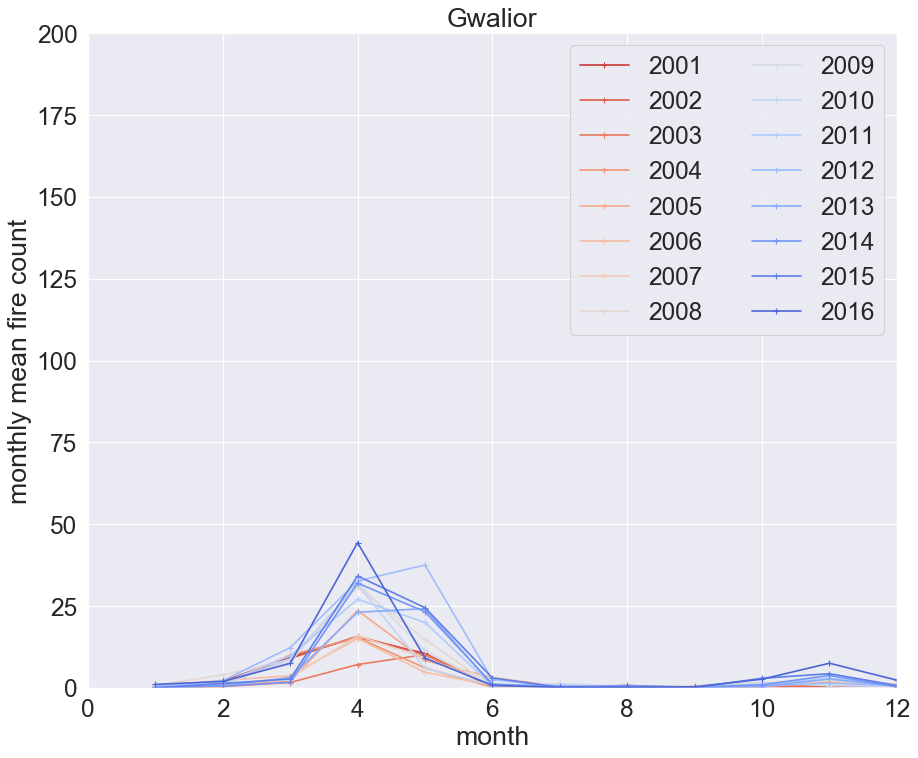

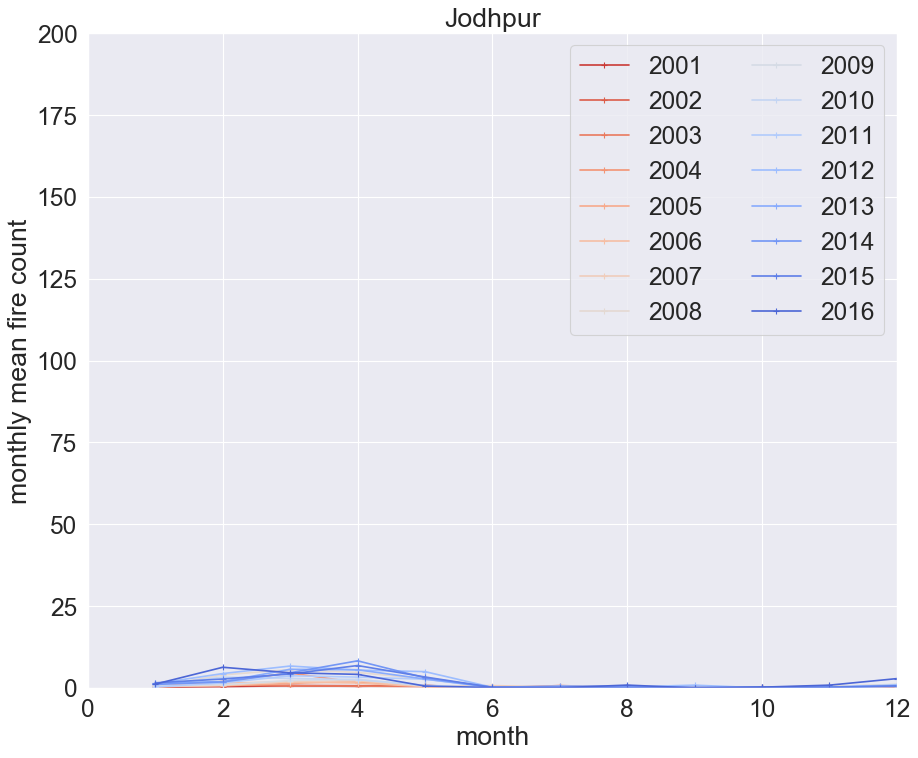

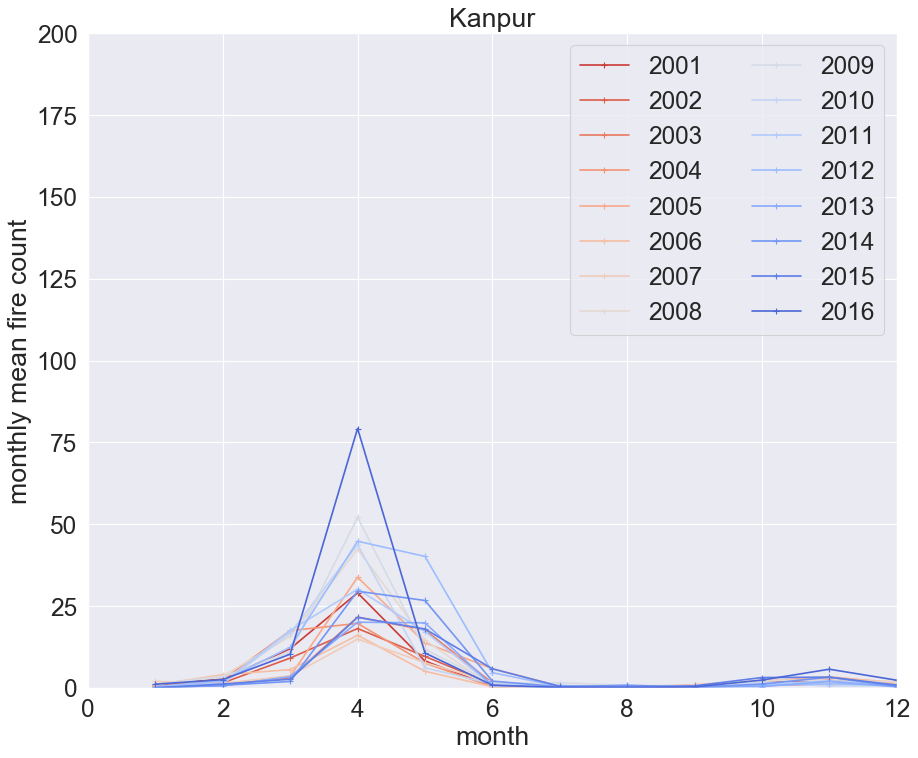

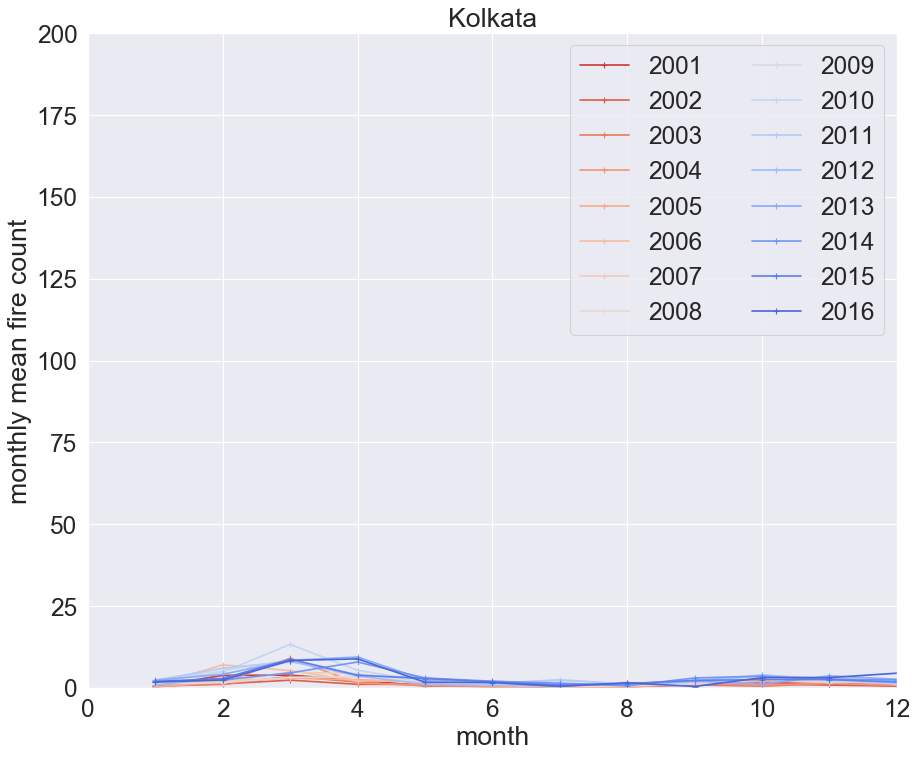

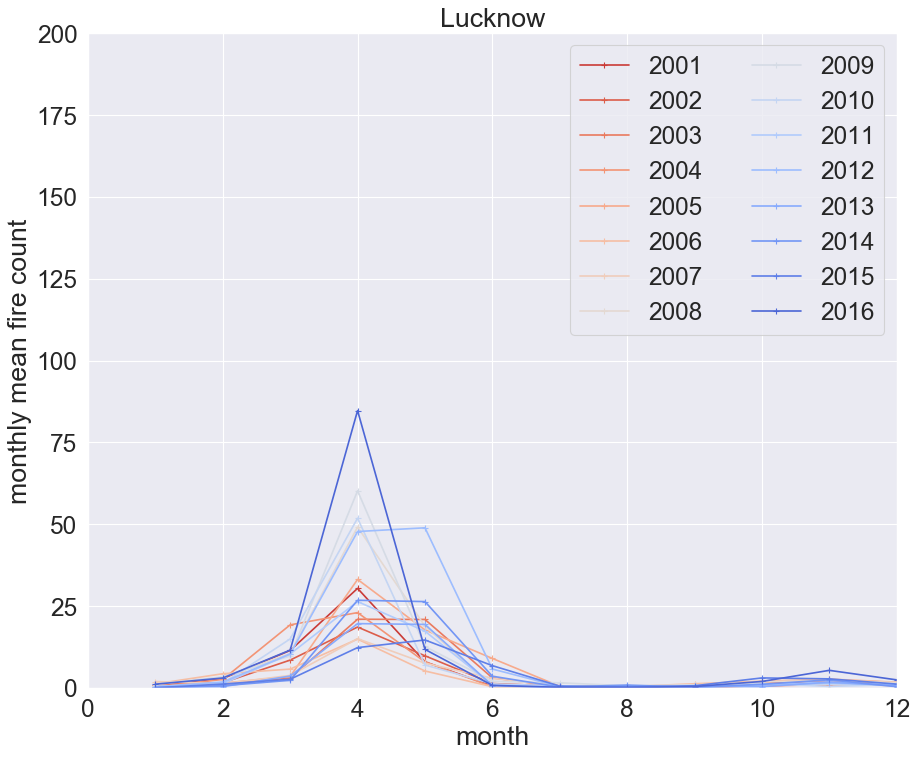

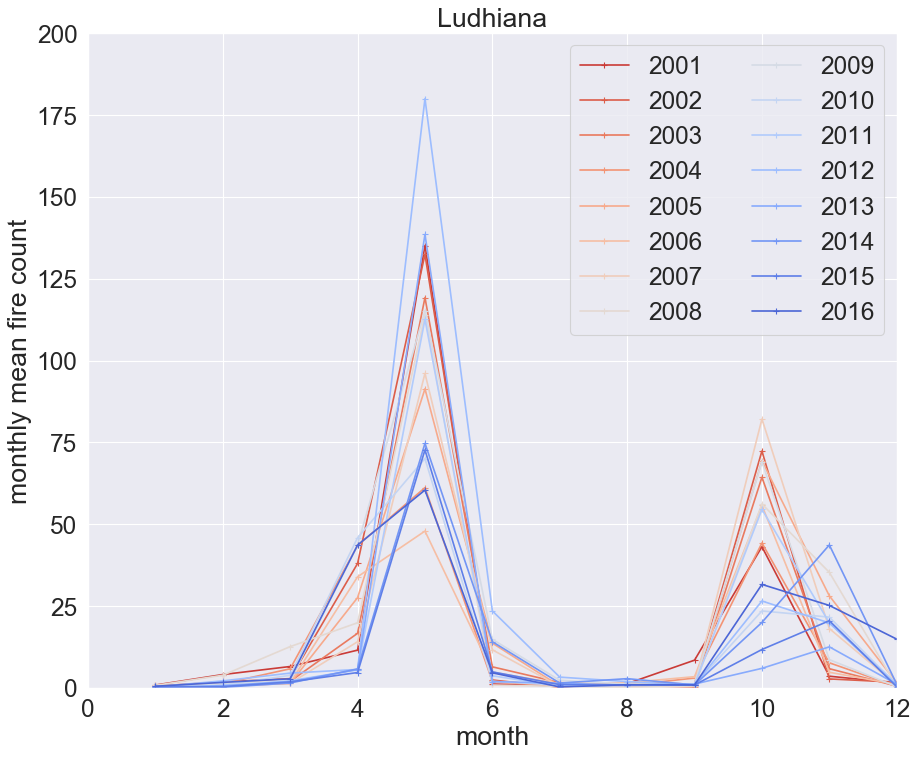

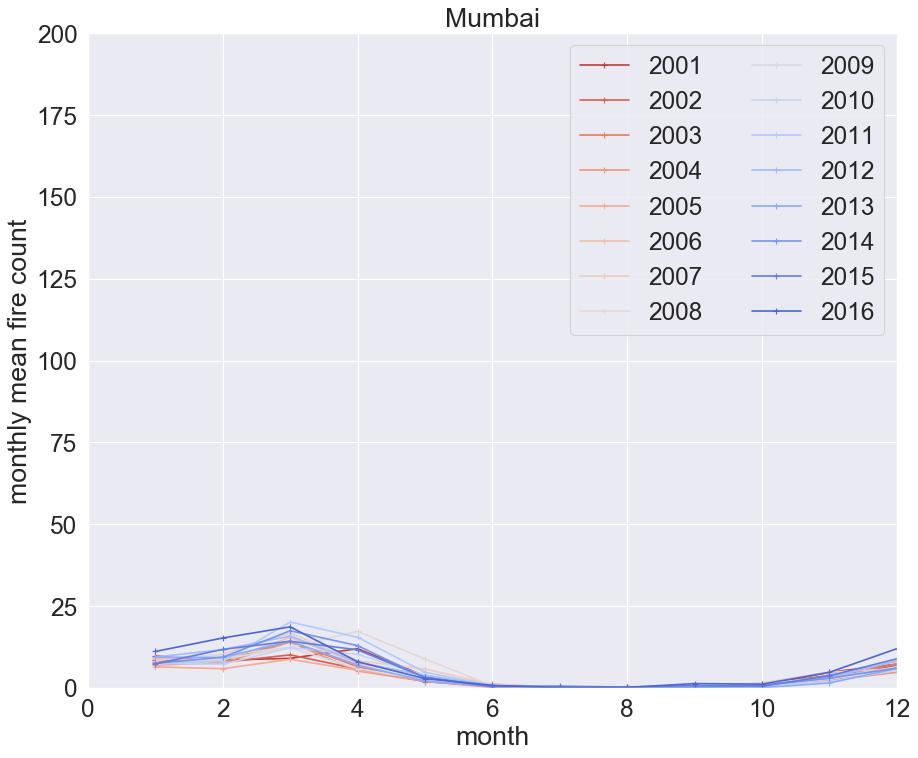

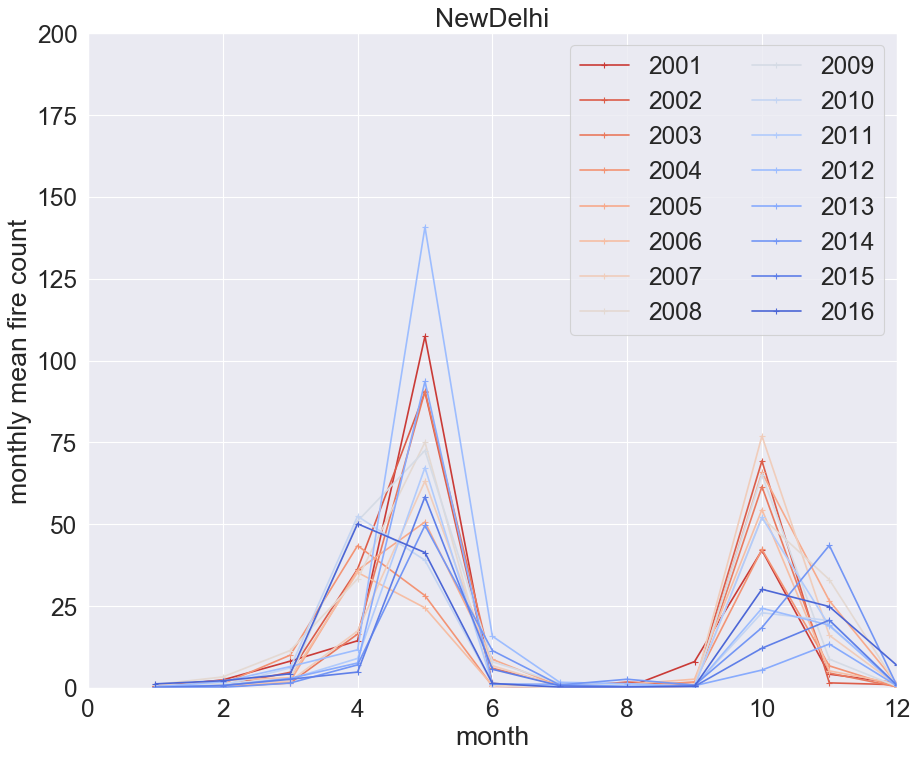

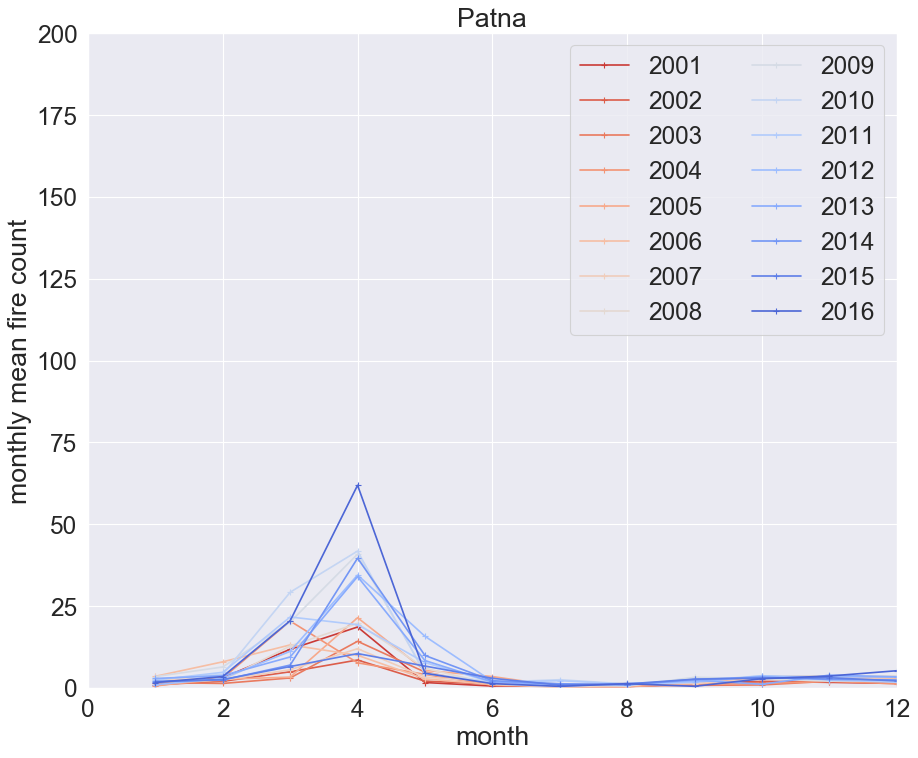

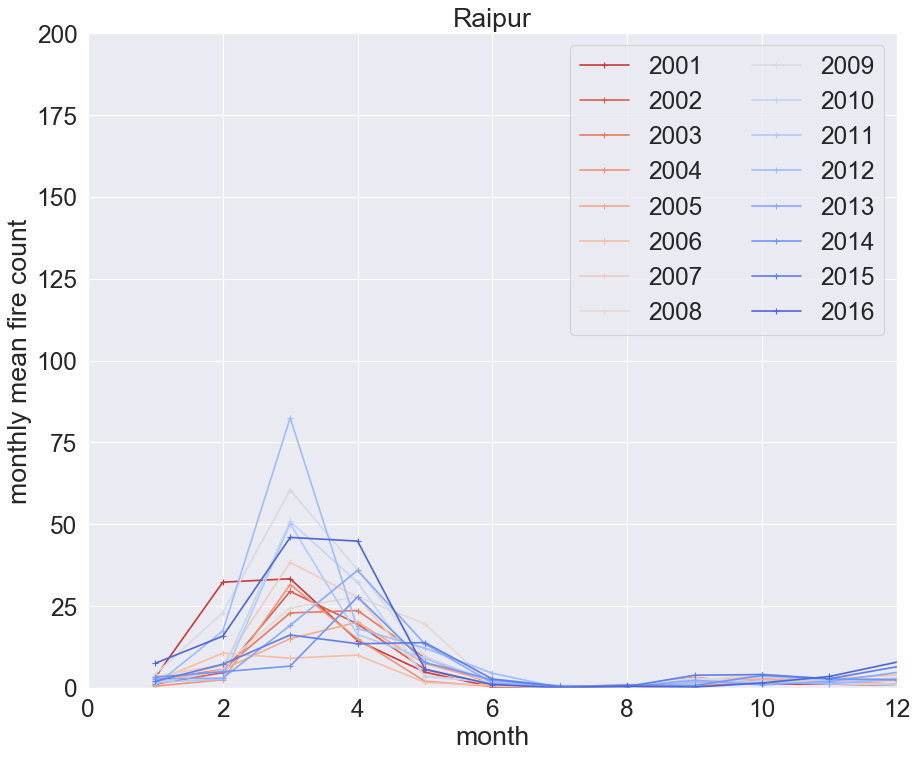

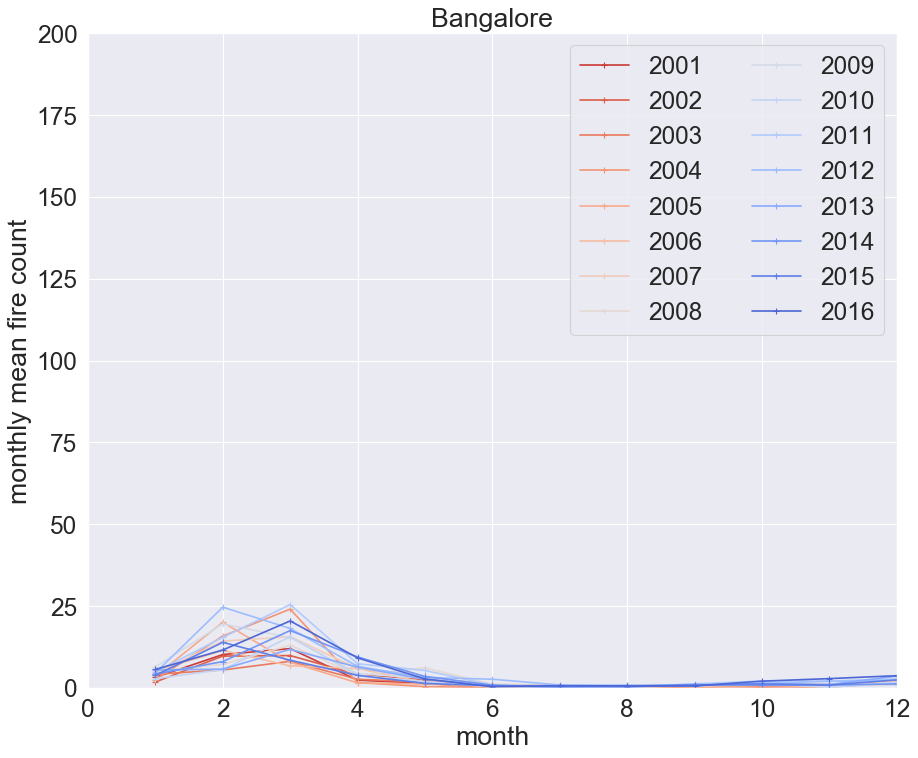

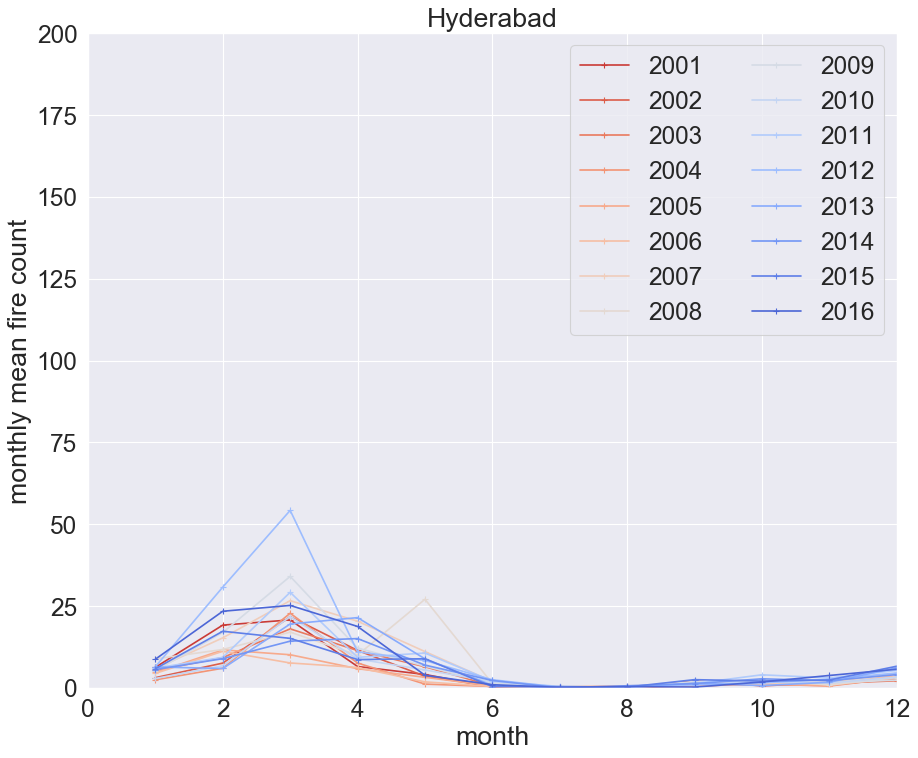

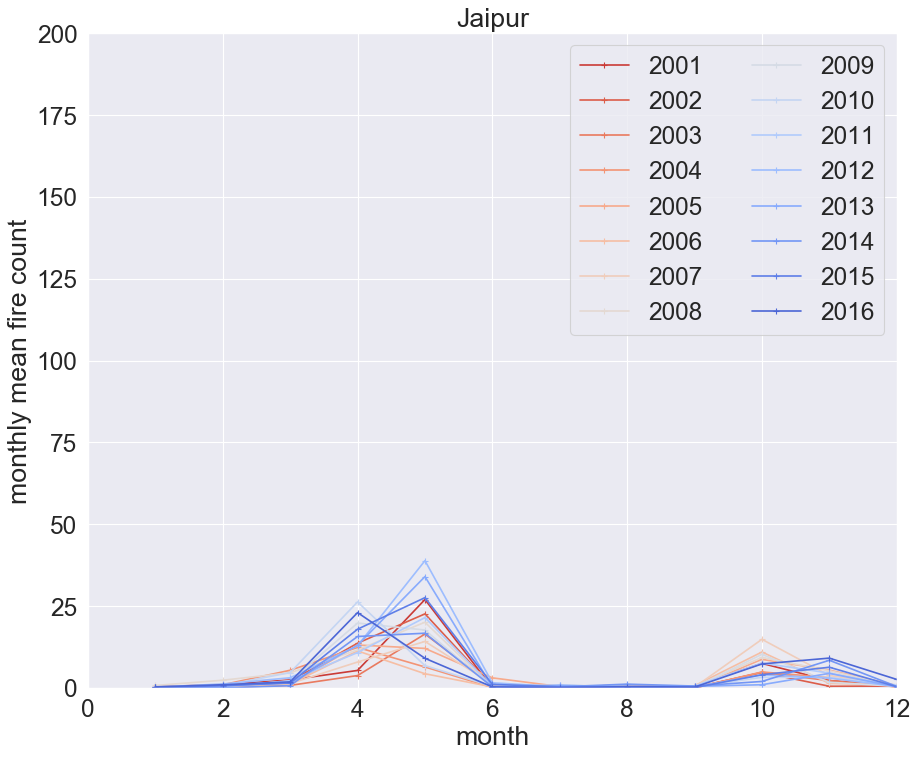

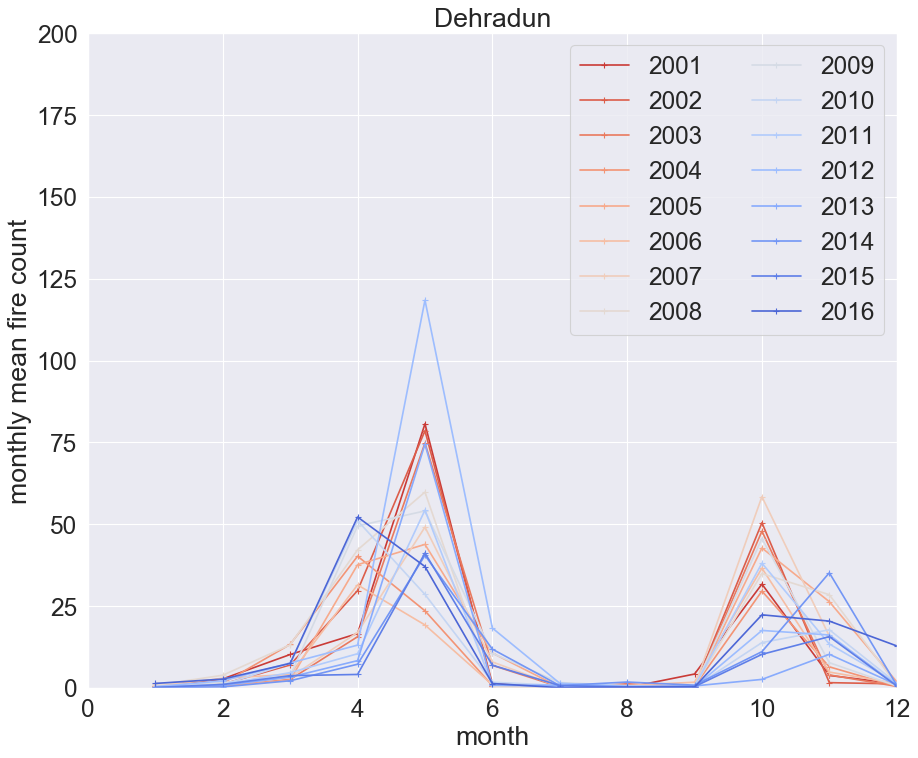

In [103]:
# def saveplot():
#call the plotting function

# gt ecity list
df_citylist = pd.read_csv(citylist_path, header=0)

# type of FRP to plot
labely = 'count_300_0'

# read the FRP
df = pd.read_csv(os.path.join(currdir, "data", "AQFRP", 'df_20cityFRP'+labely+'.csv'), header = 0)

# resample to monthly scale
resamplesumM = get_resmapled_df(df)

for index, row in df_citylist.iterrows():
    plotfrp_annual_bymonth(resamplesumM, row.Count, row.City, labely=labely, rolling = False)

In [48]:
resamplesumM

,Unnamed: 0,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C13,C14,C15,C16,C17,C18,C19,C20,doy,month
date,,,,,,,,,,,,,,,,,,,,,
2001-01-31,465,15,125,26,36,37,15,23,6,36,...,265,15,30,103,101,196,12,13,496,1
2001-02-28,1246,56,76,93,155,200,64,57,11,75,...,238,69,87,905,286,538,28,78,1274,2
2001-03-31,2205,253,83,469,207,200,279,284,21,360,...,272,246,355,1001,361,624,74,307,2239,3
2001-04-30,3105,498,117,795,358,43,665,466,15,872,...,360,433,559,434,72,197,161,499,3165,4
2001-05-31,4154,1181,39,143,4297,31,1017,327,25,255,...,114,3330,52,150,44,128,838,2502,4216,5
2001-06-30,2355,5,6,6,26,0,5,4,0,7,...,7,8,9,5,1,4,0,10,2385,6
2001-07-31,5191,6,1,11,22,9,8,5,5,8,...,1,8,18,0,10,3,5,7,5742,7
2001-08-31,6479,7,3,7,53,4,7,6,8,8,...,1,4,12,10,7,3,6,4,7068,8
2001-09-30,7185,28,12,24,255,27,28,11,4,25,...,10,242,53,95,28,64,19,128,7755,9
